+++ 
date = "2018-10-22"
title = "PDM-PCM conversion & PDM's connection to neurons"
+++

# Background

In the context of digital audio systems, PDM is a common interface between microphones and microcontrollers/signal processors. PDM signals represent analog audio signals by sampling the at a very high rate with a single bit resolution (on/off) for the amplitude. This encodes the analog signal in the density of the pulses and hence the name, Pulse Density Modulation.

For example, if you want the microphone to record an analog audio signal with a bandwidth of 24KHz (F<sub>Nyquist</sub>), you sample it at say 3.072MHz (F<sub>Nyquist</sub> * 128) with a 1-bit resolution. 

Here is what a PDM signal looks like:

![PDM](https://upload.wikimedia.org/wikipedia/commons/f/f5/Pulse-density_modulation_2_periods.gif) *The above picture is the PDM bitstream: 0101101111111111111101101010010000000000000100010011011101111111111111011010100100000000000000100101. Blue represents 1 and white represents 0. (Source: wikipedia)* 

Let's compare PDM to PCM which might be a more familiar scheme. PCM represents an analog signal by sampling at a rate greater than atleast twice the Nyquist rate and quantizing the amplitude value with N-bits. For example, 24 KHz bandwidth analog signal can be represented by a 48KHz PCM signal with 16-bits per amplitude. PCM is the standard for how uncompressed audio files are stored and manipulated eg. [WAV](https://en.wikipedia.org/wiki/WAV), [Audio CD](https://en.wikipedia.org/wiki/Compact_disc). 

Why the need for PDM then? Microphones implement PDM interfaces because they are low-cost and since PDM is digital, they are less susceptibile to interference noise. 

Intuitively, we see how information is captured in the density-- we are trading off amplitude resolution for time resolution. In this post, we'll see how we can move between PCM and PDM and look at an interesting connection to neurons. 

# PCM -> PDM

Since PCM is a more intuitive representation, let's first look at how we can transform a PCM signal into a PDM signal. 

Our PCM signal is a 16KHz sine wav with 16-bit depth:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings; warnings.filterwarnings('ignore')
from spykes.plot.neurovis import NeuroVis
from spykes.ml.neuropop import NeuroPop
from spykes.io.datasets import load_reaching_data
from scipy import signal

%matplotlib inline

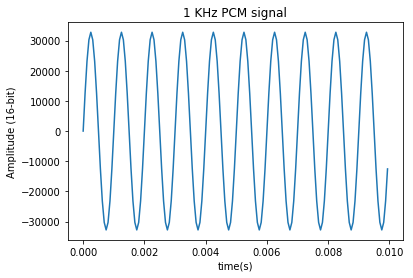

In [2]:
dur = 1 # duration in seconds
fs = 16000 # sample rate in Hz
f0 = 1000 # frequency of sine wav in Hz
b = 16 # bit depth
t = np.arange(0, dur, 1/fs)

# Discrete time signal before quantization, values between [-1, 1]
x_discrete = np.sin(2*np.pi*f0*t) 

# Quantize
def quantize(x, b, x_range):
    """ Quantize values in x with b bits 
    i.e to integers in the range [-2**(b-1), 2**(b-1)-1]
    x: 1D signal whose amplitudes are to be quantized
    b: number of bits
    x_range: tuple containing lower range limit and upper range limit
    """
    n_steps = 2**b
    delta = (x_range[1] - x_range[0])/n_steps
    bins = np.arange(x_range[0], x_range[1], delta)
    return np.digitize(x, bins) - (len(bins)/2 + 1), bins

x_pcm, bins = quantize(x_discrete, 16, (-1, 1)) # With quantization
plot_dur = 1e-2
plot_idx = int(plot_dur*fs)
plt.plot(t[0:plot_idx], x_pcm[0:plot_idx]);
plt.title("1 KHz PCM signal"); plt.xlabel('time(s)'); 
plt.ylabel('Amplitude (16-bit)');

In [3]:
print("x_pcm is in range [{}, {}]".format(min(x_pcm), max(x_pcm)))

x_pcm is in range [-32768.0, 32767.0]


The amplitude values of the PCM signal are integers in the range [-32768, 32767]. What would happen if we restricted the range to the set {0, 1} as in PDM? Lots of noise and distortion as seen in the plot below. Our sine wave becomes a square wave.

x_pdm is in set {0.0, 1.0}


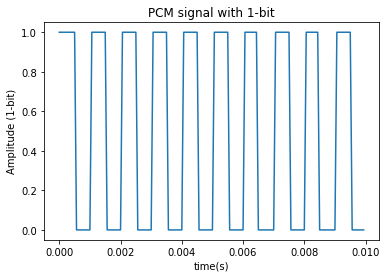

In [4]:
x_pdm, _ = quantize(x_discrete, 1, (-1, 1))
x_pdm += 1
plt.plot(t[0:plot_idx], x_pdm[0:plot_idx]);
plt.title("PCM signal with 1-bit"); plt.xlabel('time(s)'); 
plt.ylabel('Amplitude (1-bit)');
print("x_pdm is in set {}".format(set(x_pdm)))

## Dealing with quantization

The source of error in the conversion of analog to PCM is quantization. In our example, the mean squared error introduced by quantization is:

In [5]:
pcm_err = x_discrete - (x_pcm.astype(np.float)/2**(b-1)) # Rough estimate
pcm_mse = sum(pcm_err**2)/pcm_err.size
print("MSE: {} MSE(dB): {}".format(pcm_mse, 10*np.log10(pcm_mse)))

MSE: 3.1576670389676946e-10 MSE(dB): -95.00633666209488


The error is really small -- just ~3e-10. But if were to use fewer bits, the average quantization error would be substantial. And it would be maximum if we were to use just one bit.

Quantization error is best understood when modeled as uniformly distributed uncorrelated additive noise. The uniformly distributed quantization noise is related to the number of bits with the following equation:

$\Delta = {\Delta X}/{2^{b}}$

$\sigma_{e}^{2} = {\Delta}^{2}/{12}$

${\Delta X}$ is the dynamic range of the signal x. $b$ is the number of bits used in quantization. $\sigma_{e}^{2}$ is the variance of the error.

In [6]:
delta_x = 2
b = 16
delta = (delta_x/2**b)
var_e = (delta**2)/12
print("Error with {} bit: {} or {} dB".format(b, var_e, 10*np.log10(var_e)))

Error with 16 bit: 7.761021455128987e-11 or -101.10081115967061 dB


With $b=16$, ${\Delta X} = 2$, $\sigma_{e}^{2}$ = -101dB

In [7]:
b = 1
var_e = ((delta_x/2**b)**2)/12
print("Error with {} bit: {} or {} dB".format(b, var_e, 10*np.log10(var_e)))

Error with 1 bit: 0.08333333333333333 or -10.79181246047625 dB


If we were to use 1 bit as in PDM, we have a much larger total noise of -10.8dB!

So what's the trick? How do we deal with such a large quantization noise for the 1-bit system? Remember that the quantization noise is modeled as a sequence of uniformly distributed random variables that are _uncorrelated_ with each other. This means that the noise PSD is white -- equally present in all the frequencies. If we could shape the noise so that it is concentrated in the unwanted high frequencies, we could reduce the total noise affecting the low frequencies. So what do we need? We need to (a) create a new part of the signal spectrum on the high frequency side and (b) push the quantization noise to the high frequencies. (a) is achieved via oversampling and (b) via noise shaping.   


### Oversampling

We can oversample an analog signal simply by using a higher ADC sample rate. For a PCM signal, we use interpolation. Let's see how interpolating by a factor of 4 affects the 1KHz PCM signal in the frequency domain:

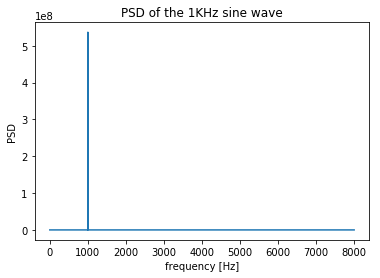

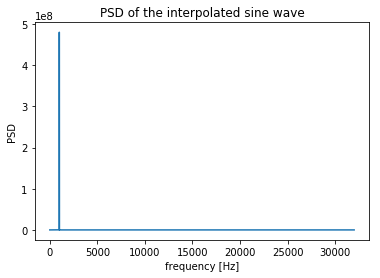

In [8]:
def plot_periodogram(sig, fs):
    f, Pxx_den = signal.periodogram(sig, fs)
    plt.plot(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD')

plot_periodogram(x_pcm, fs)
plt.title('PSD of the 1KHz sine wave')
plt.figure()

# Interpolation is achieved by upsampling followed by an interpolation filter
L = 4 # Upsampling fills in L zeros between each sample
# Interpolation filter is a low-pass filter with cut-off at pi/L
h = signal.firwin(80, np.pi/L, nyq=np.pi) 
# Perform the interpolation
x_pcm_interp = np.round((L * signal.upfirdn(h, x_pcm, up=L)))
plot_periodogram(x_pcm_interp, fs*L);
plt.title('PSD of the interpolated sine wave');

As you can see, the oversampled sine wave spectrum now has lots of empty space in the high frequencies. 

Next, we shape the quantization noise PSD to fall into the high frequencies.

### Noise shaping

The PSD of the quantization noise is flat for the oversampled signal:

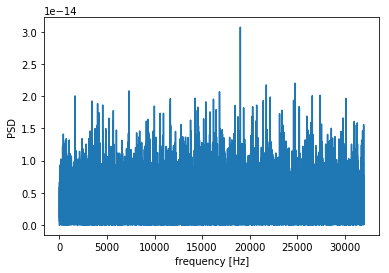

In [9]:
quant_noise = np.random.uniform(low=-delta/2, high=delta/2, size=x_pcm_interp.size)
plot_periodogram(quant_noise, fs*L)

Since our audio signal is limited to only 8KHz (for 16KHz sample rate), we want the quantization noise to have low power in those frequencies. How this is achieved in practice is by adding a feedback loop on the ADC path detailed [here](https://dsp-nbsphinx.readthedocs.io/en/nbsphinx-experiment/quantization/noise_shaping.html). We can use the  system described in the image:
![noise shaping](https://dsp-nbsphinx.readthedocs.io/en/nbsphinx-experiment/_images/noise_shaping.png)

This gives:
$x_Q[k] = \mathcal{Q} \{ x[k] - e[k] * h[k] \} = x[k] + e[k] - e[k] * h[k]$

$h[k] = \delta[k-1]$ which is simply delaying the error signal by one sample.

The final difference equation for a quantizer with noise shaping looks like:
$y[n] = x[n] + e[n] - e[n-1]$

The noise is shaped by $e[k] = e[k] - e[k] * h[k]$. To see this, we can filter the uniform quantization noise with $h[k]$.

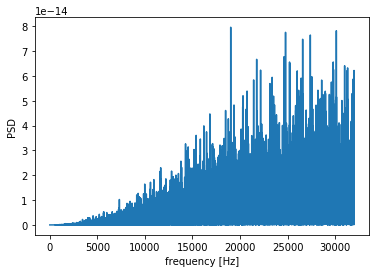

In [10]:
b = np.array([1, -1]) # Filter coefficients of h[k]
quant_noise_shaped = signal.lfilter(b, np.array([1]), quant_noise);
plot_periodogram(quant_noise_shaped, fs*L)

The low frequencies look relatively clean!

## Completing the picture

We have oversampled the signal and shaped the quantization noise. Let's put them together:

In [11]:
def pcm_to_pdm(pcm, oversample_rate):
    # Oversample
    L = oversample_rate
    # Interpolation filter is a low-pass filter with cut-off at pi/L
    h = signal.firwin(80, np.pi/L, nyq=np.pi) 
     # Perform the interpolation
    x_pcm_interp = np.round((L * signal.upfirdn(h, pcm, up=L)))

    # Quantize with noise shaping
    x_pdm = np.zeros(x_pcm_interp.size)
    qe = 0
    for i, sample in enumerate(x_pcm_interp):
        if sample >= qe:
            x_pdm[i] = 1
        else:
            x_pdm[i] = -1
        qe = x_pdm[i] - sample + qe
    return x_pdm

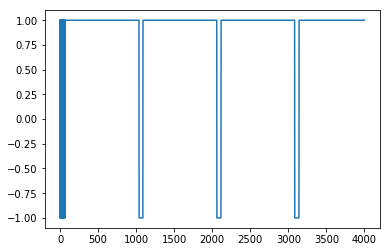

In [12]:
oversample_rate = 64
x_pdm = pcm_to_pdm(x_pcm, oversample_rate)
plt.plot(x_pdm[0:4000]);

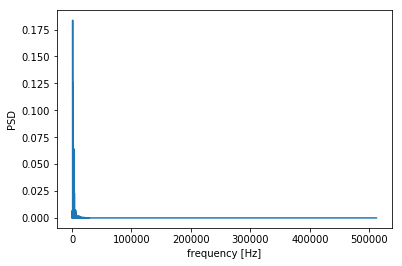

In [13]:
plot_periodogram(x_pdm, fs*oversample_rate)

# PDM -> PCM

To convert PDM back to PCM, we need to (i) apply a low-pass filter with a cut-off at the base-band audio frequency (ii) reduce the sample rate back to the original (iii) change the number of bits per amplitude from 1-bit to the desired bit depth.


In [14]:
def pdm_to_pcm(pdm, oversample_rate, b):
    """Convert a pdm signal into a pcm signal with b bits """
    # decimate function uses an anti-aliasing low-pass filter
    pcm = signal.decimate(pdm, oversample_rate, zero_phase=True, ftype='fir', n=80)
    pcm,_ = quantize(pcm, b, (-1, 1))
    return pcm

In [15]:
reconstructed_pcm = pdm_to_pcm(x_pdm, oversample_rate, 16)

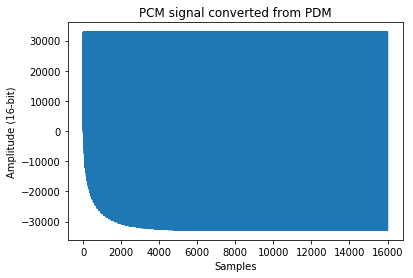

In [16]:
plt.plot(reconstructed_pcm);
plt.title("PCM signal converted from PDM");
plt.xlabel('Samples'); plt.ylabel('Amplitude (16-bit)');

The first many samples in the PCM signal represent transients that could be attributed to the decimation/low-pass filter delays.

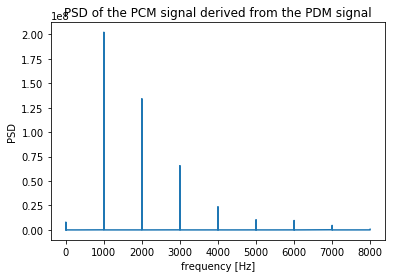

In [17]:
plot_periodogram(reconstructed_pcm, fs);
plt.title("PSD of the PCM signal derived from the PDM signal");

From the periodogram, the PCM signal looks like it has a lot of harmonic distortion. This can be mitigated by using a better noise shaping modulator.

# Connection to neurons

Neurons produce action potentials in order to pass on information to other neurons. We can record the firing of these action potentials using electrodes. The data collected is often just a list of times at which the impulses/action potentials/spikes occur. By modeling them as point processes (occuring at single points in time), we can think of them as a spike train or a PDM signal! 1 for when there is a spike and 0 for when there isn't. The density encodes the firing rate of the neuron. Once in the PDM format, we can estimate the power spectral density of the spike train for that neuron using FFT for example. 

To convert spike times into a PDM signal, we need to find the time resolution of measurement $\Delta T$ and set the sample rate of the PDM to the inverse of $\Delta T$.

Let's try it on some real data. The data is from the [spykes library](http://kordinglab.com/spykes/auto_examples/plot_reaching_dataset_example.html#sphx-glr-auto-examples-plot-reaching-dataset-example-py).

In [18]:
reach_data = load_reaching_data()

In [19]:
neuron_number = 91
spike_times = reach_data['neurons_PMd'][neuron_number - 1][0:1000]
neuron_PMd = NeuroVis(spike_times, name='PMd %d' % neuron_number)

In [20]:
# Find delta_t
spike_times = sorted(spike_times)
delta_t_min = float('inf')
for i in range(len(spike_times) - 1):
    delta_t = spike_times[i+1] - spike_times[i]
    if delta_t < delta_t_min:
        delta_t_min = delta_t
fs_neuron = 1/delta_t_min
print("Minimum time resolution needed is {} seconds. \
Corresponding sample rate: {}Hz".format(delta_t_min, fs_neuron))

Minimum time resolution needed is [0.00033333] seconds. Corresponding sample rate: [3000.]Hz


In [21]:
# Create the PDM signal
i = 0
pdm_neuron = []
for t in np.arange(0, max(spike_times), delta_t_min):
    if spike_times[i] > t and spike_times[i] < t + delta_t_min:
        i += 1
        pdm_neuron.append(1)
    pdm_neuron.append(-1)
pdm_neuron = np.array(pdm_neuron)

Text(0.5,1,'Neuron Spike Train as PDM signal')

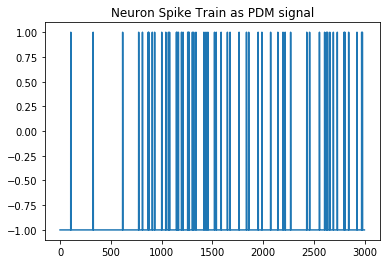

In [22]:
plt.plot(pdm_neuron[0:3000]);
plt.title("Neuron Spike Train as PDM signal")

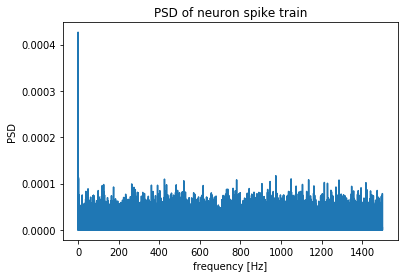

In [23]:
plt.figure()
plot_periodogram(pdm_neuron, fs_neuron);
plt.title("PSD of neuron spike train");

(0, 10)

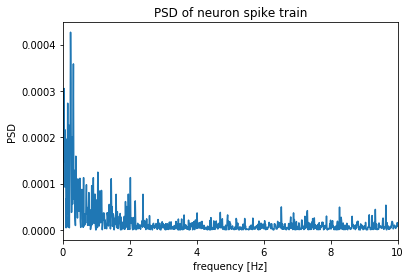

In [24]:
# PSD energy is concentrated in the low frequencies so zoom in or alternatively, decimate 
plot_periodogram(pdm_neuron, fs_neuron);
plt.title("PSD of neuron spike train");
plt.xlim(0, 10)

# Conclusion

The algorithm to go between PCM and PDM is a clever one that utilizes modeling of quantization as statistical noise. Through oversampling and noise shaping, we reduce the effects of the quantization noise on a 1-bit signal.

tl; dr conversion routines: [PCM->PDM](#completing-the-picture) & [PDM->PCM](#pdm-pcm)